<a href="https://colab.research.google.com/github/yosarawut/notebook/blob/main/multi_class_text_classification_with_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multi Class Text Classification with LSTM using TensorFlow 2.0
===

Recurrent Neural Networks, Long Short Term Memory

- https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

In [1]:
!pip install tensorflow -q

In [2]:
!pip install matplotlib -q

In [40]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
import pandas as pd
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline

print(tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.3.0


In [41]:
import pandas as pd
import numpy as np
import joblib
from time import time


def get_data(urls, sheets, types):
    data = ""
    t0 = time()
    a = []
    i = 0
    for s in sheets:
        s = pd.read_excel(urls, sheet_name=s)
        s = s[[types, 'description']]
        s['description'] = s['description'].str.lower()
        if i == 0:
            data = s.copy()
        else:
            data = pd.concat([data, s], ignore_index=True)
        i += 1
    data.columns = ['target', 'data']
    data['target'] = data['target'].apply(str)
    load_time = time() - t0
    print("Load dataset time:  %0.3fs" % load_time)

    return data

In [42]:
t0 = time()
urls = 'https://github.com/dragon-library/work_space/raw/main/HS_Code/Lab/data/hs_code.xlsx'
types = 'section'
#sheets = ['8_digit','6_digit','4_digit', 'test_01', 'Declaration_2019_10']
sheets = ['8_digit','6_digit','4_digit', '2_digit']
df = get_data(urls,sheets,types)

print(len(df))
df.columns = ['category', 'text']

print(len(df))

load_time = time() - t0
print("Load data time:  %0.3fs" % load_time)
df.sample(10)

Load dataset time:  47.878s
17222
17222
Load data time:  47.879s


,category,text
9918,18,"lenses, spectacle; unmounted, of glass, exclud..."
5434,11,"bed linen; of cotton, printed, not knitted or ..."
4870,11,carpets and other textile floor coverings; tuf...
16576,11,"fabrics; pile fabrics, including long pile fab..."
3624,7,"rubber; vulcanised, conveyor or transmission b..."
1848,5,oils and other products of the distillation of...
13854,12,"walking-sticks, seat-sticks, whips, riding-cro..."
2178,6,halogenated derivatives of acyclic hydrocarbon...
9401,17,vehicles; with both compressionignition intern...
16310,6,ferro-cerium and other pyrophoric alloys in al...


In [43]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [44]:
labels = df.category
articles = df.text

In [45]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

13777
13777
13777
3445
3445


In [46]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'a': 10,
 'and': 4,
 'for': 8,
 'in': 7,
 'not': 6,
 'of': 3,
 'or': 2,
 'other': 5,
 'than': 9}

In [47]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[527, 368, 152, 5, 9, 2531, 4, 1310, 1598, 771, 368]


In [48]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

8
200
8
200
11
200


In [49]:
print(train_padded[10])

[ 527  368  152    5    9 2531    4 1310 1598  771  368    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [50]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3445
(3445, 200)


In [51]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[6]
[6]
[6]
(13777, 1)
[3]
[3]
[3]
(3445, 1)


In [52]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

bovine animals live other than cattle and buffalo purebred breeding animals ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
---
bovine animals; live, other than cattle and buffalo - purebred breeding animals


In [56]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(32, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          320000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
Total params: 396,384
Trainable params: 396,384
Non-trainable params: 0
_________________________________________________________________


In [57]:
print(set(labels))

{'11', '9', '12', '21', '14', '13', '17', '5', '20', '1', '16', '15', '2', '3', '8', '10', '4', '7', '18', '6', '19'}


In [58]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
431/431 - 86s - loss: 1.1975 - accuracy: 0.6677 - val_loss: 0.7327 - val_accuracy: 0.8017
Epoch 2/10
431/431 - 85s - loss: 0.1484 - accuracy: 0.9659 - val_loss: 0.2880 - val_accuracy: 0.9263
Epoch 3/10
431/431 - 85s - loss: 0.0531 - accuracy: 0.9886 - val_loss: 0.2413 - val_accuracy: 0.9309
Epoch 4/10
431/431 - 88s - loss: 0.0266 - accuracy: 0.9950 - val_loss: 0.1441 - val_accuracy: 0.9620
Epoch 5/10
431/431 - 85s - loss: 0.0159 - accuracy: 0.9969 - val_loss: 0.1341 - val_accuracy: 0.9652
Epoch 6/10
431/431 - 85s - loss: 0.0126 - accuracy: 0.9975 - val_loss: 0.1092 - val_accuracy: 0.9724
Epoch 7/10
431/431 - 86s - loss: 0.0131 - accuracy: 0.9967 - val_loss: 0.2258 - val_accuracy: 0.9428
Epoch 8/10
431/431 - 85s - loss: 0.0168 - accuracy: 0.9954 - val_loss: 0.1353 - val_accuracy: 0.9652
Epoch 9/10
431/431 - 85s - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.1399 - val_accuracy: 0.9675
Epoch 10/10
431/431 - 85s - loss: 0.0063 - accuracy: 0.9988 - val_loss: 0.1234 - val_accura

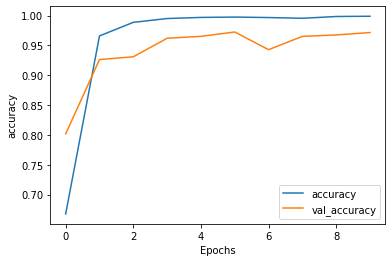

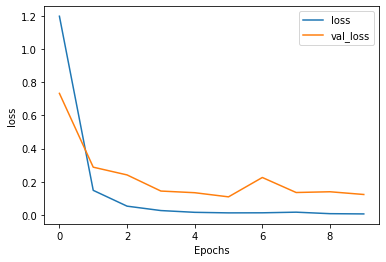

In [59]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [63]:
#save the model
import joblib
import pickle

files = "model_LSTM_section.pkl"
print("Save Model")
joblib.dump(model, "model_LSTM_section.pkl", compress=1)
print("Success")

Save Model


TypeError: ignored